### Experimentation Part 1:
Initial experimentation using the original features from the dataset across various classification models.

### Result Obtained :
I analyzed the original features and identified those that contributed meaningful predictive information. A range of baseline machine learning models with default parameters were tested. While initial performance was generally weak, introducing class-balanced weighting significantly improved results. Among all models, logistic regression demonstrated the most consistent and reliable performance.

### Future work :
Planned enhancements include incorporating additional race-relative output indicators such as a "Top 50% win rate" (whether a horse consistently finishes in the top half of the field), and experimenting with more sophisticated models to capture complex feature interactions and non-linear patterns.

## LIBRARIES

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from scipy.special import softmax

from sklearn.metrics import log_loss, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

## LOAD DATA

In [3]:
# Load data
train_data = pd.read_csv('/content/drive/MyDrive/HORSE DATA/trainData.csv')
test_data = pd.read_csv('/content/drive/MyDrive/HORSE DATA/testData.csv')

In [4]:
train_data

,Race_Time,Race_ID,Course,Distance,distanceYards,Prize,Going,Horse,Trainer,Jockey,...,Speed_2ndPreviousRun,NMFPLTO,MarketOdds_PreviousRun,MarketOdds_2ndPreviousRun,TrainerRating,JockeyRating,daysSinceLastRun,SireRating,DamsireRating,meanRunners
0,02/01/2024 19:00:00,1935,Wolverhampton,6f 20y,1340,4972,Standard,Intervention,Michael Appleby,Aiden Brookes,...,70.0,0.875000,11.03,3.60,2.377268,2.925027,7.0,2.933961,0.467149,10.25
1,02/01/2024 19:00:00,1935,Wolverhampton,6f 20y,1340,4972,Standard,Evocative Spark,Darryll Holland,Christian Howarth,...,48.0,0.181818,42.67,4.19,2.401274,2.611219,13.0,1.934009,0.459547,10.25
2,02/01/2024 19:00:00,1935,Wolverhampton,6f 20y,1340,4972,Standard,Sluzewiec,Scott Dixon,Kieran O'Neill,...,59.0,0.000000,141.13,86.83,2.824967,2.925073,50.0,2.411403,0.456616,8.00
3,02/01/2024 19:00:00,1935,Wolverhampton,6f 20y,1340,4972,Standard,Muscika,David O'Meara,Mark Winn,...,73.0,0.333333,8.97,12.86,2.317504,2.534689,38.0,2.639010,0.462397,10.00
4,02/01/2024 19:00:00,1935,Wolverhampton,6f 20y,1340,4972,Standard,Venturous,David Barron,David Probert,...,62.0,0.090909,44.84,18.20,2.292027,2.448742,24.0,2.494198,0.450770,11.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52094,31/12/2024 15:22:00,56178,Lingfield,1m 4f,2640,4711,Standard,Fullforward,Michael Madgwick,William Carson,...,43.0,0.833333,9.04,13.23,2.968319,2.767347,57.0,2.718093,0.480990,8.75
52095,31/12/2024 15:22:00,56178,Lingfield,1m 4f,2640,4711,Standard,Pablo Prince,Karen Jewell,Luke Morris,...,55.0,0.500000,48.38,5.09,3.233067,2.457842,40.0,3.019927,0.449697,11.50
52096,31/12/2024 15:22:00,56178,Lingfield,1m 4f,2640,4711,Standard,Paradoxical,Jennie Candlish,George Wood,...,58.0,0.800000,6.03,7.12,2.554826,2.555626,5.0,2.584142,0.450076,10.50
52097,31/12/2024 15:22:00,56178,Lingfield,1m 4f,2640,4711,Standard,Keen Interest,Alice Haynes,Kieran O'Neill,...,51.0,0.400000,26.57,22.16,2.443137,2.917672,15.0,2.632082,0.456602,10.75


## FUNCTION FOR EDA

In [ ]:
def classify_feature(series):
    """Classify the feature by type."""
    if pd.api.types.is_datetime64_any_dtype(series):
        return 'Datetime'

    unique_vals = series.dropna().unique()
    n_unique = len(unique_vals)

    if pd.api.types.is_numeric_dtype(series):
        if n_unique == 2:
            return 'Binary (Numeric)'
        elif n_unique < 15:
            return 'Multiclass (Numeric)'
        else:
            return 'Numerical'

    if n_unique == 2:
        return 'Binary (Categorical)'
    elif n_unique < 15:
        return 'Categorical'
    else:
        return 'High Cardinality Categorical'

def summarize_feature(series):
    """Generate a summary of key values in the feature."""
    if pd.api.types.is_numeric_dtype(series):
        return f"Mean: {series.mean():.2f}, Median: {series.median():.2f}, Std: {series.std():.2f}"
    elif pd.api.types.is_datetime64_any_dtype(series):
        return f"Min: {series.min()}, Max: {series.max()}"
    else:
        top_categories = series.value_counts(dropna=True).head(3)
        return ', '.join(f"{repr(cat)} ({cnt})" for cat, cnt in top_categories.items())

def generate_enhanced_data_report(df):
    # --------- Dataset Summary ---------
    summary = {
        'Total Rows': df.shape[0],
        'Total Features': df.shape[1],
        'Features with Missing Values': df.isnull().any().sum(),
        'Rows with Missing Values': df.isnull().any(axis=1).sum(),
        'Total Missing Values': df.isnull().sum().sum(),
        'Duplicate Rows': df.duplicated().sum()
    }
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

    # --------- Feature Report ---------
    report_rows = []

    for col in df.columns:
        series = df[col]
        feature_type = classify_feature(series)
        total = len(series)
        missing = series.isnull().sum()
        percent_missing = 100 * missing / total
        n_unique = series.nunique(dropna=True)
        example_values = series.dropna().unique()[:3]

        report_rows.append({
            'Feature': col,
            'Type': feature_type,
            '# Missing': missing,
            '% Missing': f"{percent_missing:.1f}%",
            '# Unique': n_unique,
            'Example Values': ', '.join(map(str, example_values)),
            'Summary Stats': summarize_feature(series)
        })

    feature_report_df = pd.DataFrame(report_rows)

    return summary_df, feature_report_df

## EDA REPORT

In [ ]:
# Generate EDA Report
summary, feature_report = generate_enhanced_data_report(train_data)

print("==== 📊 Dataset Summary ====")
print(summary)

print("\n==== 🧾 Feature Report ====")
feature_report

==== 📊 Dataset Summary ====
                              Value
Total Rows                    52099
Total Features                   28
Features with Missing Values     11
Rows with Missing Values        375
Total Missing Values           1133
Duplicate Rows                    0

==== 🧾 Feature Report ====


,Feature,Type,# Missing,% Missing,# Unique,Example Values,Summary Stats
0,Race_Time,High Cardinality Categorical,0,0.0%,5337,"02/01/2024 19:00:00, 02/01/2024 19:30:00, 02/0...","'28/09/2024 15:40:00' (31), '21/06/2024 17:05:..."
1,Race_ID,Numerical,0,0.0%,5337,"1935, 1936, 1937","Mean: 28265.79, Median: 28289.00, Std: 16052.77"
2,Course,High Cardinality Categorical,0,0.0%,59,"Wolverhampton, Kempton, Lingfield","'Wolverhampton' (4741), 'Newcastle' (4051), 'S..."
3,Distance,High Cardinality Categorical,0,0.0%,277,"6f 20y, 5f 21y, 1m 4f 51y","'6f' (4708), '1m' (4289), '7f' (4058)"
4,distanceYards,Numerical,0,0.0%,277,"1340, 1121, 2691","Mean: 1846.85, Median: 1759.00, Std: 629.02"
5,Prize,Numerical,0,0.0%,267,"4972, 2983, 6281","Mean: 9117.52, Median: 5154.00, Std: 15586.66"
6,Going,Categorical,0,0.0%,7,"Standard, Heavy, Soft","'Standard' (22104), 'Good' (11213), 'Good To F..."
7,Horse,High Cardinality Categorical,0,0.0%,9723,"Intervention, Evocative Spark, Sluzewiec","'Visibility' (30), 'Port Noir' (29), 'Alafdhal..."
8,Trainer,High Cardinality Categorical,0,0.0%,715,"Michael Appleby, Darryll Holland, Scott Dixon","'Tim Easterby' (995), 'Charlie Johnston' (859)..."
9,Jockey,High Cardinality Categorical,0,0.0%,605,"Aiden Brookes, Christian Howarth, Kieran O'Neill","'Billy Loughnane' (856), 'Rossa Ryan' (803), '..."


## INPUT AND OUTPUT

In [5]:
train_data.columns

Index(['Race_Time', 'Race_ID', 'Course', 'Distance', 'distanceYards', 'Prize',
       'Going', 'Horse', 'Trainer', 'Jockey', 'betfairSP', 'Position',
       'timeSecs', 'pdsBeaten', 'NMFP', 'Runners', 'Age', 'Speed_PreviousRun',
       'Speed_2ndPreviousRun', 'NMFPLTO', 'MarketOdds_PreviousRun',
       'MarketOdds_2ndPreviousRun', 'TrainerRating', 'JockeyRating',
       'daysSinceLastRun', 'SireRating', 'DamsireRating', 'meanRunners'],
      dtype='object')

In [6]:
INP = [
    # Historical form / fitness
    'Speed_PreviousRun',
    'Speed_2ndPreviousRun',
    'MarketOdds_PreviousRun',
    'MarketOdds_2ndPreviousRun',
    'daysSinceLastRun',

    # Ratings (aggregated skill indicators)
    'TrainerRating',
    'JockeyRating',
    'SireRating',
    'DamsireRating',

    # Demographics
    'Age',

    # Race configuration (distance = performance factor)
    'distanceYards',
    'Going'
]

In [7]:
# Add Binary Target: Top50%
train_data['Top50%'] = (train_data['Position'] <= (train_data['Runners'] // 2)).astype(int)

In [8]:
train_data[['Position','Top50%']].head(15)

,Position,Top50%
0,2,1
1,3,1
2,5,0
3,6,0
4,4,0
5,1,1
6,6,0
7,4,0
8,5,0
9,1,1


In [9]:
# Add Inverse Position + Empirical Probability

# Avoid division by zero — handle only valid positions
train_data = train_data[train_data['Position'] > 0].copy()

train_data['inv_pos'] = 1 / train_data['Position']
train_data['empirical_prob'] = train_data.groupby('Race_ID')['inv_pos'].transform(lambda x: x / x.sum())

In [10]:
train_data[['inv_pos','empirical_prob','Position','Top50%']].head(15)

,inv_pos,empirical_prob,Position,Top50%
0,0.500000,0.204082,2,1
1,0.333333,0.136054,3,1
2,0.200000,0.081633,5,0
3,0.166667,0.068027,6,0
4,0.250000,0.102041,4,0
5,1.000000,0.408163,1,1
6,0.166667,0.064279,6,0
7,0.250000,0.096419,4,0
8,0.200000,0.077135,5,0
9,1.000000,0.385675,1,1


In [11]:
# Confirm that probabilities sum to 1 per race
train_data.groupby('Race_ID')['empirical_prob'].sum().describe()

,empirical_prob
count,5.337000e+03
mean,1.000000e+00
std,1.057584e-16
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [12]:
train_data['Win'] = (train_data['Position'] == 1).astype(int)

In [13]:
train_data[['Position','Win']].head(14)

,Position,Win
0,2,0
1,3,0
2,5,0
3,6,0
4,4,0
5,1,1
6,6,0
7,4,0
8,5,0
9,1,1


## CLEAN DATA


Remove NAN data points

In [14]:
train_data[['daysSinceLastRun','Position']].head(15)

,daysSinceLastRun,Position
0,7.0,2
1,13.0,3
2,50.0,5
3,38.0,6
4,24.0,4
5,98.0,1
6,28.0,6
7,17.0,4
8,7.0,5
9,80.0,1


In [15]:
# Fill NA values

# Show count of NaNs per column
train_data.isna().sum()

,0
Race_Time,0
Race_ID,0
Course,0
Distance,0
distanceYards,0
Prize,0
Going,0
Horse,0
Trainer,0
Jockey,0


In [16]:
nan_col = ['Speed_PreviousRun','Speed_2ndPreviousRun','NMFPLTO','MarketOdds_PreviousRun','MarketOdds_2ndPreviousRun','TrainerRating','JockeyRating','daysSinceLastRun','SireRating','DamsireRating','meanRunners']

In [17]:
# First, group by Horse and get medians for each feature
for col in nan_col:
    train_data[col] = train_data.groupby('Horse')[col].transform(lambda x: x.fillna(x.median()))

In [18]:
# Still There are NaNs so remove those races
# First, flag races with any NaNs in selected inputs
incomplete_races = train_data[train_data[nan_col].isna().any(axis=1)]['Race_ID'].unique()
len(incomplete_races)

81

In [19]:
# Drop those races entirely
train_data = train_data[~train_data['Race_ID'].isin(incomplete_races)].reset_index(drop=True)

In [20]:
# Still incomplete race info?
incomplete_races = train_data[train_data[nan_col].isna().any(axis=1)]['Race_ID'].unique()
len(incomplete_races)

0

## TOP PERFORMERS

<ipython-input-44-4874e5d7043d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_horses.values, y=top_horses.index, palette='viridis')
<ipython-input-44-4874e5d7043d>:11: UserWarning: Glyph 127943 (\N{HORSE RACING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127943 (\N{HORSE RACING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


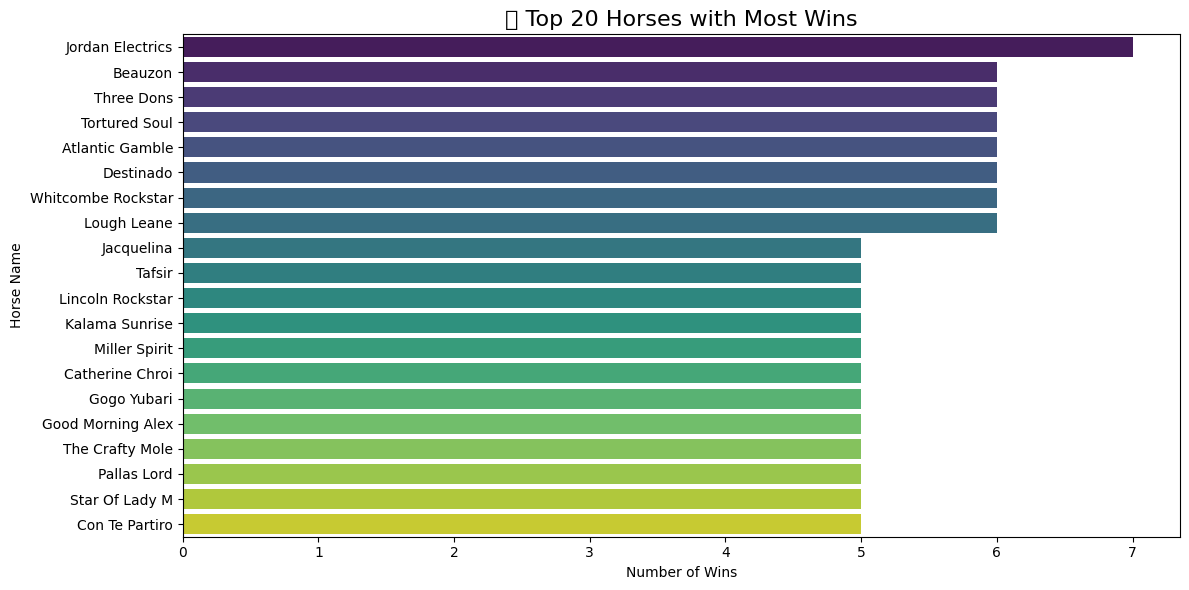

In [ ]:
horse_win_counts = train_data.groupby('Horse')['Win'].sum().sort_values(ascending=False)

# Take top 20 winning horses
top_horses = horse_win_counts.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_horses.values, y=top_horses.index, palette='viridis')
plt.title('🏇 Top 20 Horses with Most Wins', fontsize=16)
plt.xlabel('Number of Wins')
plt.ylabel('Horse Name')
plt.tight_layout()
plt.show()

## PREDICT WIN AS OUTPUT AND RESULTS

### SPLIT X and Y

In [21]:
# STEP 1: Get unique Race_IDs
unique_races = train_data['Race_ID'].unique()

In [22]:
# STEP 2: Stratify by win outcomes
train_races, val_races = train_test_split(
    unique_races,
    test_size=0.3,
    random_state=42
)

In [23]:
# STEP 3: Filter data based on race split
train_mask = train_data['Race_ID'].isin(train_races)
val_mask = train_data['Race_ID'].isin(val_races)

X_train = train_data.loc[train_mask, INP].copy()
y_train = train_data.loc[train_mask, 'Win'].values

X_val = train_data.loc[val_mask, INP].copy()
y_val = train_data.loc[val_mask, 'Win'].values

### SCALE FEATURES

In [24]:
going_rank = {
    'Firm': 1,
    'Good To Firm': 2,
    'Good': 3,
    'Good To Soft': 4,
    'Soft': 5,
    'Heavy': 6,
    'Standard': 7
}

In [25]:
# Identify numeric columns (all except 'Going')
numeric_features = [col for col in INP if col != 'Going']

In [26]:
# STEP 4: Preprocess
X_train['Going'] = X_train['Going'].map(going_rank)
X_val['Going'] = X_val['Going'].map(going_rank)

# Scale numeric features
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

In [27]:
len(X_val)

15220

### INPUT : X

In [28]:
X_train.isna().sum()

,0
Speed_PreviousRun,0
Speed_2ndPreviousRun,0
MarketOdds_PreviousRun,0
MarketOdds_2ndPreviousRun,0
daysSinceLastRun,0
TrainerRating,0
JockeyRating,0
SireRating,0
DamsireRating,0
Age,0


### MODELS

In [29]:
# Add Race_ID back to validation set
# Assuming val_data is the DataFrame corresponding to X_val
val_data = X_val.copy()
val_data['Race_ID'] = train_data.loc[val_mask, 'Race_ID'].values
val_data['TrueWin'] = y_val

In [34]:
def softmax_probs(x):
    e_x = np.exp(x - np.max(x))  # numerical stability
    return e_x / e_x.sum()

In [35]:
# Define models with class balancing
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier( random_state=42),
    "RandomForest": RandomForestClassifier( random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "SVC": SVC(probability=True,random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}")
    model.fit(X_train, y_train)

    # Raw prediction probabilities
    raw_probs = model.predict_proba(X_val)[:, 1]

    # Attach to validation set
    val_data['raw_prob'] = raw_probs

    # Apply softmax per race
    val_data['softmax_prob'] = val_data.groupby('Race_ID')['raw_prob'].transform(lambda x: softmax_probs(x.values))


    # Predicted class from raw (not softmax)
    y_pred = (val_data['raw_prob'] >= 0.5).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) else 0

    # Log Loss / Brier using softmax-normalized probs
    true_labels = val_data['TrueWin'].values
    softmax_probs_pred = val_data['softmax_prob'].values

    logloss = log_loss(true_labels, softmax_probs_pred)
    brier = brier_score_loss(true_labels, softmax_probs_pred)
    bal_acc = balanced_accuracy_score(true_labels, y_pred)

    results.append({
        "Model": name,
        "Balanced Accuracy": round(bal_acc, 4),
        "Sensitivity (Recall)": round(sensitivity, 4),
        "Specificity": round(specificity, 4),
        "Log Loss": round(logloss, 4),
        "Brier Score": round(brier, 4),
    })
    print(results)

# Show results
results_df = pd.DataFrame(results)
results_df


Training LogisticRegression
[{'Model': 'LogisticRegression', 'Balanced Accuracy': np.float64(0.5), 'Sensitivity (Recall)': np.float64(0.0), 'Specificity': np.float64(1.0), 'Log Loss': 0.3259, 'Brier Score': np.float64(0.0915)}]

Training DecisionTree
[{'Model': 'LogisticRegression', 'Balanced Accuracy': np.float64(0.5), 'Sensitivity (Recall)': np.float64(0.0), 'Specificity': np.float64(1.0), 'Log Loss': 0.3259, 'Brier Score': np.float64(0.0915)}, {'Model': 'DecisionTree', 'Balanced Accuracy': np.float64(0.5157), 'Sensitivity (Recall)': np.float64(0.152), 'Specificity': np.float64(0.8793), 'Log Loss': 0.3315, 'Brier Score': np.float64(0.0929)}]

Training RandomForest
[{'Model': 'LogisticRegression', 'Balanced Accuracy': np.float64(0.5), 'Sensitivity (Recall)': np.float64(0.0), 'Specificity': np.float64(1.0), 'Log Loss': 0.3259, 'Brier Score': np.float64(0.0915)}, {'Model': 'DecisionTree', 'Balanced Accuracy': np.float64(0.5157), 'Sensitivity (Recall)': np.float64(0.152), 'Specificity':

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[{'Model': 'LogisticRegression', 'Balanced Accuracy': np.float64(0.5), 'Sensitivity (Recall)': np.float64(0.0), 'Specificity': np.float64(1.0), 'Log Loss': 0.3259, 'Brier Score': np.float64(0.0915)}, {'Model': 'DecisionTree', 'Balanced Accuracy': np.float64(0.5157), 'Sensitivity (Recall)': np.float64(0.152), 'Specificity': np.float64(0.8793), 'Log Loss': 0.3315, 'Brier Score': np.float64(0.0929)}, {'Model': 'RandomForest', 'Balanced Accuracy': np.float64(0.5005), 'Sensitivity (Recall)': np.float64(0.0013), 'Specificity': np.float64(0.9997), 'Log Loss': 0.3248, 'Brier Score': np.float64(0.0913)}, {'Model': 'XGBoost', 'Balanced Accuracy': np.float64(0.5038), 'Sensitivity (Recall)': np.float64(0.0114), 'Specificity': np.float64(0.9961), 'Log Loss': 0.3251, 'Brier Score': np.float64(0.0914)}]

Training LightGBM
[LightGBM] [Info] Number of positive: 3688, number of negative: 32125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can

,Model,Balanced Accuracy,Sensitivity (Recall),Specificity,Log Loss,Brier Score
0,LogisticRegression,0.5000,0.0000,1.0000,0.3259,0.0915
1,DecisionTree,0.5157,0.1520,0.8793,0.3315,0.0929
2,RandomForest,0.5005,0.0013,0.9997,0.3248,0.0913
3,XGBoost,0.5038,0.0114,0.9961,0.3251,0.0914
4,LightGBM,0.4999,0.0000,0.9998,0.3249,0.0913
5,SVC,0.5000,0.0000,0.9999,0.3273,0.0918


In [58]:
# Define models with class balancing
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=42),
    "LightGBM": lgb.LGBMClassifier(class_weight='balanced', random_state=42),
    "SVC": SVC(probability=True, class_weight='balanced', random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}")
    model.fit(X_train, y_train)

    # Raw prediction probabilities
    raw_probs = model.predict_proba(X_val)[:, 1]

    # Attach to validation set
    val_data['raw_prob'] = raw_probs

    # Softmax normalization per race
    val_data['softmax_prob'] = val_data.groupby('Race_ID')['raw_prob'].transform(lambda x: softmax(x))

    # Predicted class from raw (not softmax)
    y_pred = (val_data['raw_prob'] >= 0.5).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) else 0

    # Log Loss / Brier using softmax-normalized probs
    true_labels = val_data['TrueWin'].values
    softmax_probs = val_data['softmax_prob'].values

    logloss = log_loss(true_labels, softmax_probs)
    brier = brier_score_loss(true_labels, softmax_probs)
    bal_acc = balanced_accuracy_score(true_labels, y_pred)

    results.append({
        "Model": name,
        "Balanced Accuracy": round(bal_acc, 4),
        "Sensitivity (Recall)": round(sensitivity, 4),
        "Specificity": round(specificity, 4),
        "Log Loss": round(logloss, 4),
        "Brier Score": round(brier, 4),
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


Training LogisticRegression

Training SVC

Training DecisionTree

Training RandomForest

Training XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training LightGBM
[LightGBM] [Info] Number of positive: 3688, number of negative: 32125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 35813, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
                Model  Balanced Accuracy  Sensitivity (Recall)  Specificity  \
0  LogisticRegression             0.5855                0.6358       0.5352   
1                 SVC             0.5000                0.0000       1.0000   
2        DecisionTree             0.5157                0.1387       0.8927   
3        RandomForest             0.5000                0.0000       0.9999   
4             XGBoost        

In [59]:
results_df

,Model,Balanced Accuracy,Sensitivity (Recall),Specificity,Log Loss,Brier Score
0,LogisticRegression,0.5855,0.6358,0.5352,0.3236,0.0911
1,SVC,0.5000,0.0000,1.0000,0.3257,0.0915
2,DecisionTree,0.5157,0.1387,0.8927,0.3309,0.0928
3,RandomForest,0.5000,0.0000,0.9999,0.3252,0.0914
4,XGBoost,0.5531,0.3306,0.7755,0.3229,0.0910
5,LightGBM,0.5828,0.4997,0.6659,0.3220,0.0908
